# Processing & EDA

In [1]:
!pip install surprise
import pandas as pd
import numpy as np
import time
import datetime
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

In [2]:
# you can get data here https://disk.yandex.ru/d/_08r1l5-TnYcrA and https://disk.yandex.ru/d/Ub5b27CO2oUwrA

from google.colab import drive
drive.mount('/content/drive/')


movies = pd.read_csv('/content/drive/MyDrive/sirius/movies.csv')
ratings = pd.read_parquet('/content/drive/MyDrive/sirius/ratings.parquet')
ratings

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [3]:
genres = set()  # Какие жанры есть
for i in movies.genres.unique():
    for j in i.split("|"):
        genres.add(j)
genres = list(genres)

In [4]:
for genre in genres:
    movies[genre] = movies['genres'].apply(lambda x: 1 if genre in x.split("|") else 0)

In [5]:
def f(x):
    if "(" in x:
        t = x.split(" ")[-1].replace("(", "").replace(")", "")
        if t.isdigit():
            return t
    return "0"


movies["year"] = movies["title"].apply(lambda x: f(x))

In [6]:
mean_ratings = ratings.groupby('movieId')['rating'].mean()

movies['mean_rating'] = movies['movieId'].map(mean_ratings)

## Распределение по годам

Text(0.5, 1.0, 'Распределение фильмов по годам')

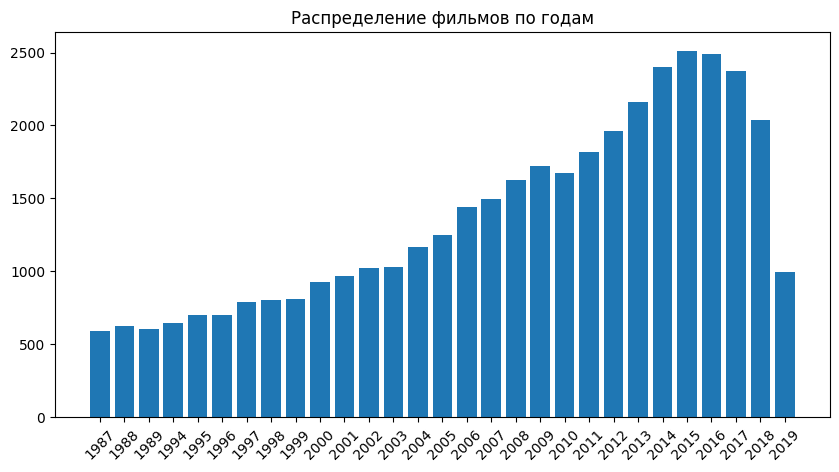

In [7]:
y = movies["year"].value_counts().sort_values()[-29:].sort_index()
x = y.index
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xticks(rotation = 45)
plt.title("Распределение фильмов по годам")

## Распределение по жанрам

Text(0.5, 1.0, 'Распределение по жанрам')

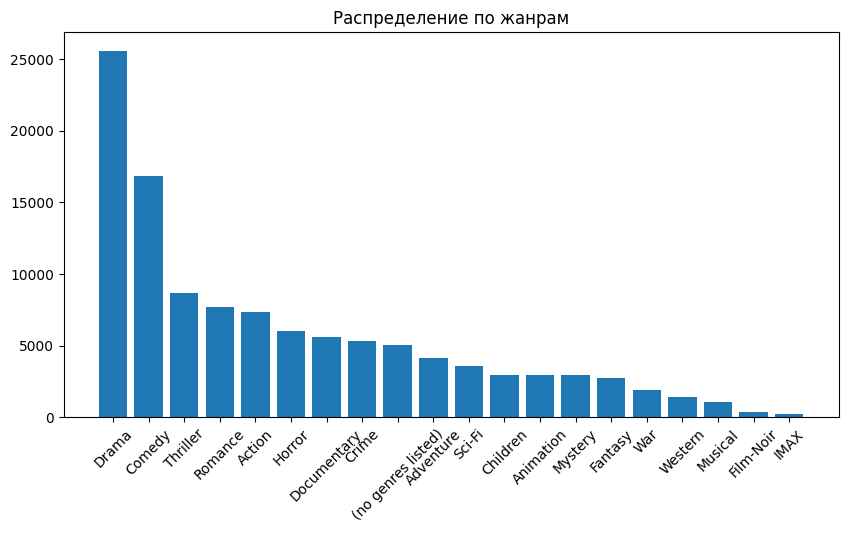

In [8]:
y = movies[genres].apply(lambda x: sum(x)).sort_values(ascending=False)
x = y.index
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xticks(rotation = 45)
plt.title("Распределение по жанрам")

## Средний рейтинг по жанрам

In [9]:
res = []
for genre in genres:
    res.append([genre, np.mean(movies[movies[genre] == 1]["mean_rating"])])
res.sort(key=lambda x: x[1], reverse=True)

Text(0.5, 1.0, 'Средний рейтинг по жанрам')

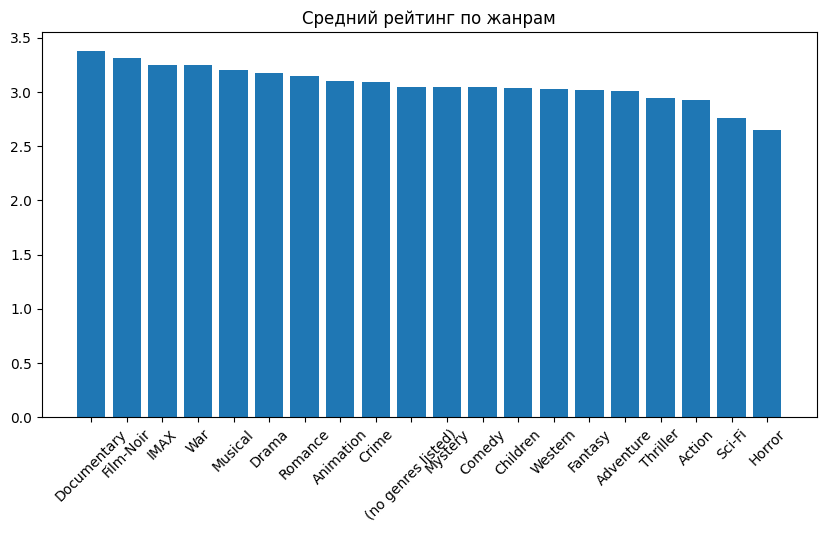

In [10]:
y = list(map(lambda x: x[1], res))
x = list(map(lambda x: x[0], res))
plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xticks(rotation = 45)
plt.title("Средний рейтинг по жанрам")

## Распределение кол-ва отзывов на юзера

In [11]:
ratings["userId"].value_counts().sort_values()

36207        20
31691        20
135005       20
135012       20
51779        20
          ...  
20055      7488
33844      7919
137293     8913
80974      9178
72315     32202
Name: userId, Length: 162541, dtype: int64

25-й, 50-й и 75-й персентили: [2685.   2991.5  3723.25]


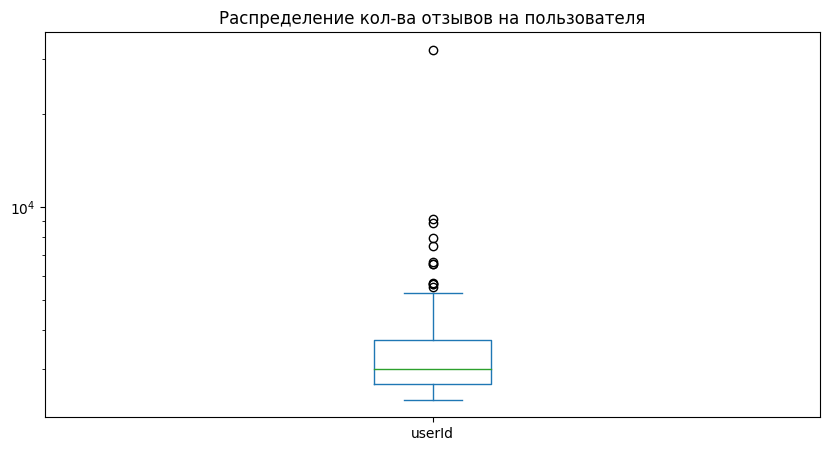

In [12]:
y = ratings["userId"].value_counts().sort_values().iloc[::-1][:250]
x = range(1, len(y) + 1)
plt.figure(figsize=(10, 5))
y.plot.box()
plt.yscale('log')
plt.title("Распределение кол-ва отзывов на пользователя")
print(f'25-й, 50-й и 75-й персентили: {np.percentile(y.values, [25, 50, 75])}')

## Data processing

In [13]:
ratings.sort_values(by='timestamp', inplace=True)
ratings = ratings.iloc[-10**6*3:]   # Берем 3 миллиона последних оценок

Text(0.5, 1.0, 'Распреление оценки в отзыве')

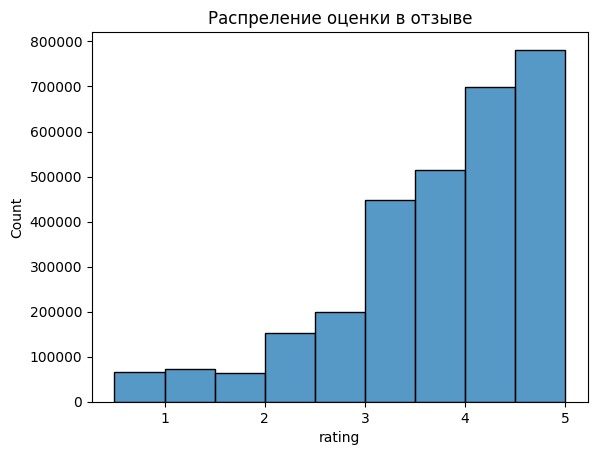

In [14]:
sns.histplot(ratings['rating'], binwidth=0.5)
plt.title('Распреление оценки в отзыве')

In [15]:
# df = ratings.merge(movies, on = 'movieId')
df = ratings.copy()
df

,userId,movieId,rating,timestamp
20272555,131794,97304,3.5,1504294607
20272528,131794,30707,4.0,1504294611
20272556,131794,104841,3.0,1504294614
37185,290,8807,2.0,1504294615
20272560,131794,112556,3.5,1504294620
...,...,...,...,...
13207880,85523,168252,4.0,1574327479
1284508,8642,202101,2.0,1574327512
13207893,85523,204704,4.0,1574327533
1284464,8642,122914,4.0,1574327549


In [16]:
df.nunique()

userId         21035
movieId        51292
rating            10
timestamp    2664708
dtype: int64

In [17]:
# df['timestamp'] = df['timestamp'].values.astype(np.int64) // 10 ** 9
print('Первая запись была', datetime.date.fromtimestamp(df['timestamp'].min()).isoformat())
print('Последняя', datetime.date.fromtimestamp(df['timestamp'].max()).isoformat())

Первая запись была 2017-09-01
Последняя 2019-11-21


In [18]:
def split_reviews(x, days):
  if max_timestamp-x<86400*days:  # Самые последние записи идут в тест
    return 'test'
  elif max_timestamp-x<86400*days*2: # Чуть более ранние идут в валидацию
    return 'val'
  else:  # Остальное - трейн
    return 'train'

max_timestamp = df['timestamp'].max()
groups = df['timestamp'].apply(lambda x: split_reviews(x, 20)) # Разбиваем на трейн/валидацию/тест
groups

20272555    train
20272528    train
20272556    train
37185       train
20272560    train
            ...  
13207880     test
1284508      test
13207893     test
1284464      test
13207877     test
Name: timestamp, Length: 3000000, dtype: object

Text(0.5, 1.0, 'Распреление времени отзыва по train/val/split')

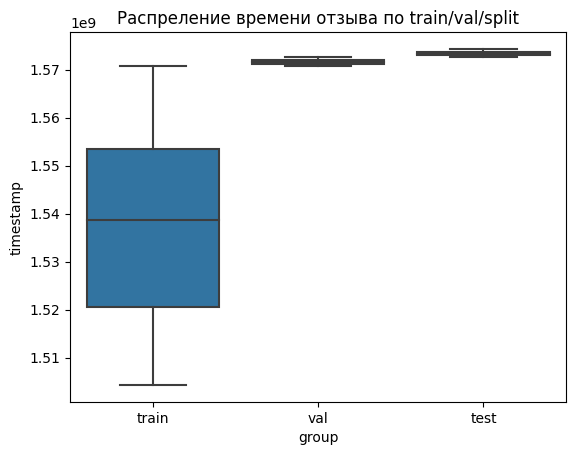

In [19]:
groups.name = 'group'
sns.boxplot(data = pd.concat([groups, df['timestamp']], axis=1), x='group', y='timestamp')
plt.title('Распреление времени отзыва по train/val/split')

In [20]:
df['group'] = groups
df['group'].value_counts()

train    2874897
test       65538
val        59565
Name: group, dtype: int64

In [21]:
def split_users(x): # Если для пользователя в валидацию/тест меньше 20 отзывов попало, то не учитываем их
  if len(x[x=='test'])>=20:
    return 'test'
  elif len(x[x=='val'])>=20:
    return 'val'
  else:
    return 'train'

data_splits = df.groupby('userId').agg({'group': split_users})
data_splits

,group
userId,
3,train
4,test
14,train
33,train
35,train
...,...
162501,train
162516,train
162521,train


In [22]:
data_splits.value_counts()

group
train    20152
test       475
val        408
dtype: int64

In [23]:
df = df.merge(data_splits, left_on = 'userId', right_index=True)
groups = {'train': 'train', 'val': 'val/test', 'test': 'val/test'}
df['group_user'] = df['group_y'].apply(lambda x: groups[x])
df['group_review'] = df['group_x']
df.drop(columns = ['group_x', 'group_y'], inplace=True)
df

,userId,movieId,rating,timestamp,group_user,group_review
20272555,131794,97304,3.5,1504294607,train,train
20272528,131794,30707,4.0,1504294611,train,train
20272556,131794,104841,3.0,1504294614,train,train
20272560,131794,112556,3.5,1504294620,train,train
20272535,131794,48394,4.0,1504294627,train,train
...,...,...,...,...,...,...
13207885,85523,195165,3.0,1574327424,val/test,test
13207868,85523,109487,4.5,1574327445,val/test,test
13207880,85523,168252,4.0,1574327479,val/test,test
13207893,85523,204704,4.0,1574327533,val/test,test


In [24]:
def split_data_final(x):
  user, review = x
  if review!='train' and user=='train':
    return -1
  else:
    return review

df['group_review'] = df[['group_user', 'group_review']].apply(split_data_final, axis=1)
df = df[df.group_review!=-1]
df

,userId,movieId,rating,timestamp,group_user,group_review
20272555,131794,97304,3.5,1504294607,train,train
20272528,131794,30707,4.0,1504294611,train,train
20272556,131794,104841,3.0,1504294614,train,train
20272560,131794,112556,3.5,1504294620,train,train
20272535,131794,48394,4.0,1504294627,train,train
...,...,...,...,...,...,...
13207885,85523,195165,3.0,1574327424,val/test,test
13207868,85523,109487,4.5,1574327445,val/test,test
13207880,85523,168252,4.0,1574327479,val/test,test
13207893,85523,204704,4.0,1574327533,val/test,test


<Axes: xlabel='group_review', ylabel='timestamp'>

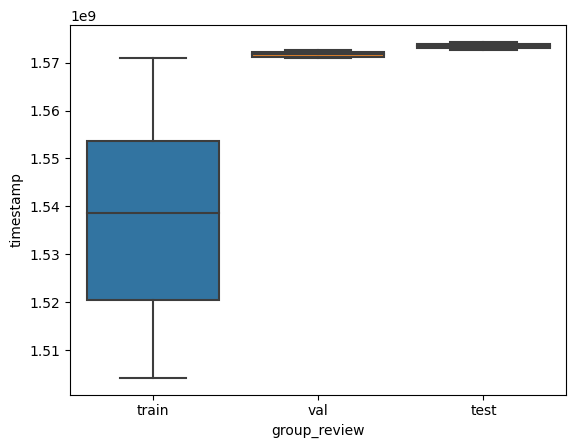

In [25]:
sns.boxplot(data = df, x='group_review', y='timestamp')

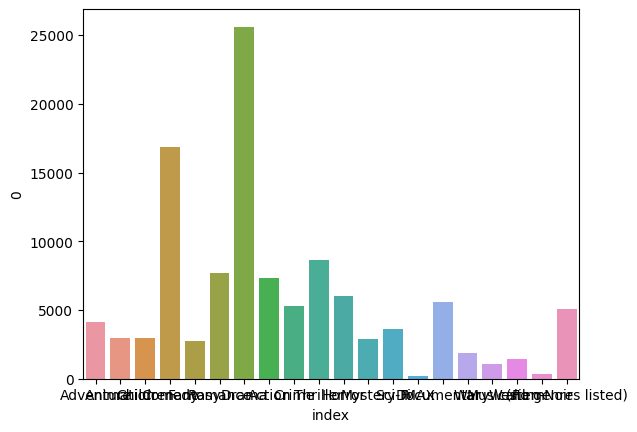

In [26]:
genres_count = defaultdict(int)

for _, genres in movies['genres'].apply(lambda x: x.split('|')).items():
  for genre in genres:
    # if j == 'IMAX':
    #   print(i)
    genres_count[genre]+=1

# genres_count
sns.barplot(pd.Series(genres_count).reset_index(), x='index', y=0)
sns.set(rc={'figure.figsize':(24, 16)})

# SVD

In [27]:
import surprise
from surprise import Dataset, SVD, SVDpp, NMF
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy

In [28]:
%%time

reader = surprise.reader.Reader()

data = Dataset.load_from_df(df[df.group_review =='train'][["userId", "movieId", "rating"]], reader=reader)
trainset = data.build_full_trainset()


# print("Grid Search...")
# param_grid = {"n_factors": [100, 200, 300, 400], "n_epochs": [20], "lr_all": [0.002, 0.005]}
# grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
# grid_search.fit(data)
# algo = grid_search.best_estimator["rmse"]


algo = SVD(random_state=0, verbose=True)
algo.fit(trainset)

data_val = Dataset.load_from_df(df[df.group_review =='val'][["userId", "movieId", "rating"]], reader=reader)
valset = data_val.build_full_trainset()
valset = valset.build_testset()

predictions = algo.test(valset)
print("Validation results")
accuracy.rmse(predictions), accuracy.mae(predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Validation results
RMSE: 0.9138
MAE:  0.6961
CPU times: user 50.3 s, sys: 614 ms, total: 50.9 s
Wall time: 53 s


(0.9138138604108154, 0.6961058879207608)

In [29]:
check_test_metrics = 0

if check_test_metrics:

  data = Dataset.load_from_df(df[df.group_review.isin(['train', 'val'])][["userId", "movieId", "rating"]].iloc[:], reader=reader)
  trainset = data.build_full_trainset()


  algo_test = SVD(random_state=0, verbose=True)
  algo_test.fit(trainset)

  data_test = Dataset.load_from_df(df[df.group_review=='test'][["userId", "movieId", "rating"]], reader=reader)
  testset = data_test.build_full_trainset()
  testset = testset.build_testset()
  predictions = algo_test.test(testset)

  print("Test results")
  accuracy.rmse(predictions), accuracy.mae(predictions)

RMSE: 0.8692
MAE:  0.6677

In [30]:
algo.pu.shape, algo.qi.shape

((20418, 100), (50452, 100))

In [31]:
unique_movies_train = np.unique(df[df.group_review=='train']['movieId'])
unique_users_train = np.unique(df[df.group_review=='train']['userId'])
unique_users_val = np.unique(df[df.group_review=='val']['userId'])

le_movies = dict(zip(unique_movies_train, np.arange(len(unique_movies_train)))) # Чтобы восстановить movieId
le_movies_reverse = {value: key for key, value in le_movies.items()} # Чтобы восстановить movieId

## Нахождение похожих фильмов

In [32]:
movieId=33
n = 10 # Cколько похожих фильмов найти

assert movieId in unique_movies_train, 'Данный фильм не встречался в тренировочной выборке!!!'

similar_movies = pd.Series(cosine_similarity(algo.pu, algo.pu[le_movies[movieId]].reshape(-1, 1).T).reshape(-1))
similar_movies = similar_movies.sort_values(ascending=False).iloc[1:n+1]

similar_movies = similar_movies.reset_index()
similar_movies.columns = ['movieId', 'Релевантность']
similar_movies['Релевантность'] = (similar_movies['Релевантность']+1)*50
similar_movies['movieId'] = similar_movies['movieId'].apply(lambda x: le_movies_reverse[x])
similar_movies.index = list(range(1, n+1))
print(f'Топ-{n} похожих фильмов для фильма {movieId}:')
similar_movies

Топ-10 похожих фильмов для фильма 33:


,movieId,Релевантность
1,3428,70.900025
2,51,69.109037
3,2056,68.737437
4,117547,68.670511
5,107778,67.661359
6,43,67.395249
7,86628,67.241981
8,89217,67.130596
9,69278,66.959849
10,1539,66.899516


## Рекомендация фильмов

In [33]:
cosines_users = pd.DataFrame(cosine_similarity(algo.pu)) # Косинусные расстояния между эмбеддингами пользователей
cosines_users.columns = unique_users_train
cosines_users.index = unique_users_train

top_300_count_movies = df[df.group_review=='train']['movieId'].value_counts().iloc[:300].index.values # 300 самых популярных фильмов

In [34]:
userId = 33
n = 10 # Cколько рекомендаций вывести


preds_user = pd.Series()

unique_movies_user = np.unique(df[(df.group_review=='train') & (df.userId==userId)]['movieId'])  # Какие фильмы уже посмотрел

if userId not in cosines_users:
  print('Новый пользователь!')
  for movie in top_300_count_movies:
    preds_user.loc[movie] = algo.predict(userId, movie).est  # Если пользователь новый, советуем ему фильмы из 300 самыз популярных

  preds_user = preds_user[~preds_user.index.isin(unique_movies_user)]  # Убираем то, что смотрел уже
  preds_user = preds_user.sort_values(ascending=False).iloc[:n]

  recs = pd.DataFrame([preds_user.index.values, preds_user.values]).T
  recs.columns=['movieId', 'Релевантность']
  recs['Релевантность'] = (recs['Релевантность']*20).round(2)
  recs['movieId'] = recs['movieId'].astype(int)

else:
  cosines = pd.Series(cosines_users[userId]).sort_values(ascending=False).iloc[1:6]  # топ-5 близкиз пользователей

  decent_rating = 4  # С какого порога считаем, что фильм понравился

  similar = df[(df.group_review=='train') &(df.userId.isin(cosines.index.values) & (df.rating>=decent_rating))] # Фильмы, которые понравились похожим пользователям
  similar = similar[~similar.movieId.isin(unique_movies_user)]
  count=5
  while similar['movieId'].nunique()<200:  # Можем взять и больше 5 похожих пользователей, надо минимум 200 фильмов отобрать
    cosines = cosines_users[userId].iloc[[count]]
    similar = pd.concat([similar, df[(df.group_review=='train') &(df.userId.isin(cosines.index.values) & (df.rating>=decent_rating))]], axis=0)
    similar = similar[~similar.movieId.isin(unique_movies_user)]
    count+=1

  similar = similar.sort_values('rating', ascending=False)


  for movie in np.unique(similar['movieId']):
    preds_user.loc[movie] = algo.predict(userId, movie).est


  preds_user = preds_user.sort_values(ascending=False).iloc[:n]

  recs = pd.DataFrame([preds_user.index.values, preds_user.values]).T
  recs.columns=['movieId', 'Релевантность']
  recs['Релевантность'] = (recs['Релевантность']*20).round(2)
  recs['movieId'] = recs['movieId'].astype(int)

recs

,movieId,Релевантность
0,170705,93.33
1,1203,87.11
2,1270,86.05
3,182723,85.27
4,112552,85.11
5,171011,84.97
6,1225,83.95
7,364,83.83
8,1201,83.20
9,3578,83.05


### Для всех пользователей (около 6 минут)

In [36]:
recs = pd.DataFrame([], columns=['Recommendations', 'Predictions'])

n = 20 # Cколько рекомендаций вывести

for user in tqdm(unique_users_val, desc='Getting recommendation'):
  preds_user = pd.Series()

  unique_movies_user = np.unique(df[(df.group_review=='train') & (df.userId==user)]['movieId'])

  if user not in cosines_users:
    top_300_count_movies
    for movie in top_300_count_movies:
      preds_user.loc[movie] = algo.predict(user, movie).est

    preds_user = preds_user.sort_values(ascending=False).iloc[:n]
    recs.loc[user] = (preds_user.index.values, preds_user.values)
    continue


  cosines = pd.Series(cosines_users[user]).sort_values(ascending=False).iloc[1:6]

  decent_rating = 4

  similar = df[(df.group_review=='train') &(df.userId.isin(cosines.index.values) & (df.rating>=decent_rating))]
  similar = similar[~similar.movieId.isin(unique_movies_user)]
  count=5
  while similar['movieId'].nunique()<200:
    cosines = cosines_users[user].iloc[[count]]
    similar = pd.concat([similar, df[(df.group_review=='train') &(df.userId.isin(cosines.index.values) & (df.rating>=decent_rating))]], axis=0)
    similar = similar[~similar.movieId.isin(unique_movies_user)]
    count+=1

  similar = similar.sort_values('rating', ascending=False)


  for movie in np.unique(similar['movieId']):
    preds_user.loc[movie] = algo.predict(user, movie).est


  preds_user = preds_user.sort_values(ascending=False).iloc[:n]

  recs.loc[user] = (preds_user.index.values, preds_user.values)

recs

Getting recommendation:   5%|▍         | 24/506 [00:15<05:20,  1.50it/s]


KeyboardInterrupt: ignored

# DeepFM and FNN

In [ ]:
! pip install -q deepctr
! pip install -q tensorflow==2.8.0

In [37]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.feature_column import SparseFeat, get_feature_names
from deepctr.models import DeepFM
import scipy
import deepctr

In [ ]:
sparse_features = ["movieId", "userId", "timestamp"]
target = ['rating']

for f in sparse_features:
    un = np.unique(df[f])
    di = dict(zip(un, list(range(len(un)))))
    df[f] = df[f].apply(lambda x: di[x])  # [1, 3, 6, 7] -> [0, 1, 2, 3]

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique(), embeddings_initializer=tf.keras.initializers.RandomNormal()) for feat in sparse_features]
fixlen_feature_columns

In [ ]:
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(feature_names,type(feature_names))

In [ ]:
train_model_input = {name:df[df.group_review=='train'][name].values for name in feature_names}
val_model_input = {name:df[df.group_review=='val'][name].values for name in feature_names}
test_model_input = {name:df[df.group_review=='test'][name].values for name in feature_names}

In [ ]:
train_FNN = 0
if train_FNN:
  model = deepctr.models.FNN(linear_feature_columns, dnn_feature_columns, task='regression',
                            dnn_dropout=0.2)
  model.compile(optimizer="adam", loss="mse", metrics=['mse', 'mae'])
  history = model.fit(train_model_input, df[df.group_review=='train']['rating'].values, batch_size=2**9, epochs=10, verbose=True, validation_data=(val_model_input, df[df.group_review=='val']['rating'].values))

In [ ]:
train_DeepFM = 0
if train_DeepFM:

  model = deepctr.models.DeepFM(linear_feature_columns, dnn_feature_columns, task='regression',
                            dnn_dropout=0.2)
  model.compile(optimizer="adam", loss="mse", metrics=['mse', 'mae'])
  history = model.fit(train_model_input, df[df.group_review=='train']['rating'].values, batch_size=2**9, epochs=5, verbose=True, validation_data=(val_model_input, df[df.group_review=='val']['rating'].values))

In [ ]:
if train_DeepFM or train_FNN:

  from sklearn.metrics import mean_squared_error, mean_absolute_error
  pred= model.predict(val_model_input, batch_size=2**10)

  print('Validation RMSE:', mean_squared_error(df[df.group_review=='val']['rating'], pred)**0.5)
  print('Validation MAE:', mean_absolute_error(df[df.group_review=='val']['rating'], pred))

In [ ]:
if train_DeepFM or train_FNN:
  pred= model.predict(test_model_input, batch_size=2**10)

  print('Test RMSE:', mean_squared_error(df[df.group_review=='test']['rating'], pred)**0.5)
  print('Test MAE:', mean_absolute_error(df[df.group_review=='test']['rating'], pred))